In [1]:
# ====== #
# Import #
# ====== #

# essential libraries
import os
import math
import random
from datetime import timedelta
from datetime import datetime as dt

# storing and anaysis
import numpy as np
import pandas as pd

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import calmap # 설치
import folium # 설치

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

#한글깨짐 방지(0420)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import cufflinks as cf #설치(0420)
cf.go_offline(connected=True) #pandas와 같이 plotly에서도 간단한 시각화 지원

# for offline ploting
# ===================
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "notebook_connected"


Bad key "text.kerning_factor" on line 4 in
C:\Users\chan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

In [2]:
path = '../covid'

In [3]:
os.chdir('data')
file_name_list = os.listdir()
file_name_list

['Case.csv',
 'PatientInfo.csv',
 'PatientRoute.csv',
 'Region.csv',
 'SearchTrend.csv',
 'SeoulFloating.csv',
 'Time.csv',
 'TimeAge.csv',
 'TimeGender.csv',
 'TimeProvince.csv',
 'Weather.csv']

# Time : Analysis based on Time

In [4]:
time = pd.read_csv('Time.csv')
timeAge = pd.read_csv('timeAge.csv')
timeGender = pd.read_csv('timeGender.csv')
timeProvince = pd.read_csv('TimeProvince.csv',)

In [100]:
layout_setting = {'xaxis_title':'Month','yaxis_title':'Number','font':dict(size=18,color='#60606e',family='Franklin Gothic' )}

In [101]:
# 시간에 따른 확진자 추이
fig = go.Figure()
fig.add_trace(go.Scatter(x=time['date'],y=time['released'],
             mode='lines+markers', name='released'))
fig.add_trace(go.Scatter(x=time['date'],y=time['confirmed'],
             mode='lines+markers', name='confirmed'))
fig.add_trace(go.Scatter(x=time['date'],y=time['deceased'],
             mode='lines+markers', name='deceased'))

fig.update_layout(title='<b>시간에 따른 확진자 추이</b>', **layout_setting)
fig.show()

In [102]:
# 검사자 수와 음성판정자 수
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=time['date'],y=time['negative'],
             mode='lines+markers', name='Negative'))
fig.add_trace(go.Scatter(x=time['date'],y=time['test'],
             mode='lines+markers', name='Test'))

fig.update_layout(title='<b>검사자 수와 음성판정자 수</b>', **layout_setting)
fig.show()

In [103]:
# 신천지 첫 확진자 이후 : 일단위 확진자 수
"""
우한 바이러스 첫등장 11월14일
우한지역 첫 확진자 발생 12월1일
국내 첫 확진자 1월 21일
대구 신천지 첫 확진자 2월17일 (31번)
"""
time['date'] = pd.to_datetime(time['date'])
start = dt.strptime('2020-02-17', '%Y-%m-%d')
mid = dt.strptime('2020-03-05', '%Y-%m-%d')

fig = go.Figure()
clr = [DEFAULT_PLOTLY_COLORS[3] if start <= d <= mid else DEFAULT_PLOTLY_COLORS[7] for d in time['date']]
fig.add_trace(go.Bar(x=time['date'],y=time['confirmed'].diff(), 
                     name='confirmed', marker=dict(color=clr)))

fig.update_layout(title='<b>일단위 확진자 수</b>',**layout_setting)

fig.show()

In [104]:
# 시간에 따른 전체적인 추이
time.index = time.date
time_df=time.drop(['date','time'],axis=1,errors='ignore')

fig = go.Figure()
fig.add_trace(go.Scatter(x=time['date'],y= time['released'],
             mode='lines+markers', name='released'))
fig.add_trace(go.Scatter(x=time['date'],y= time['confirmed'],
             mode='lines+markers', name='confirmed'))
fig.add_trace(go.Scatter(x=time['date'],y= time['deceased'],
             mode='lines+markers', name='deceased'))
fig.add_trace(go.Scatter(x=time['date'],y= time['confirmed']-time['released'],
             mode='lines+markers', name='isolated'))

fig.update_layout(title='<b>시간에 따른 전체 추이</b>', **layout_setting)

fig.update_xaxes(rangeslider_visible=True)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="2m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

'2020-03-05'

확진자가 급속하게 먼저 늘어나고 이후 완치된 사람들이 늘어감
확진자 증가 속도가 감소하면서 전체적인 숫자가 줄어드는 것을 확인할 수 있음

In [126]:
fig_1 = px.line(time, x='date', y='negative', color_discrete_sequence=[dth])
fig_2 = px.line(time, x='date', y='test', color_discrete_sequence=[rec])

fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(fig_1['data'][0])
fig.add_trace(fig_2['data'][0])

fig.update_layout(title='<b>검사자 수와 음성판정자 수</b>',
                   xaxis_title='Month',
                   yaxis_title='Number',
                 font=dict(size=18,color='#60606e',family='Franklin Gothic' ))
fig.show()

In [105]:
# timeAge_Date = timeAge.pivot_table(index = ['date'],columns=['age'], aggfunc=sum)
fig = px.bar(timeAge, x='date', y='confirmed',
             hover_data=['age'], color='age', )

fig.update_layout(title='<b>연령별 확진자 추이</b>', **layout_setting)
fig.show()

1. 확진자 수는 20대가 훨씬 많다는 것을 알 수 있습니다. 
2. 50대가 두번째로 많은 확진자 연령층 입니다.
3. 70, 80대 확진자 수 자체는 매우 많지 않다는 것을 알 수 있습니다.

In [106]:
timeAge_Date = timeAge.pivot_table(index = ['date'],columns=['age'], aggfunc=sum)

timeAge_Date['deceased']

fig = go.Figure()
for col in timeAge_Date['deceased'].columns:
    fig.add_trace(go.Scatter(x=timeAge_Date.index,y= timeAge_Date['deceased'][col],
                 mode='lines+markers', name=col))
# ... #
fig.update_layout(title='<b>연령별 사망자 추이</b>', **layout_setting)
fig.show()

20대가 확진자 수가 월등히 많음에도 사망자 숫자 자체가 80, 70대에서 더 많은 것은 나이에 따른 사망확률이 매우 높음을 알 수 있습니다.

In [120]:
Gender_Date = timeGender.pivot_table(index = ['date'],columns=['sex'], aggfunc=sum)
Gender_Confirmed = Gender_Date['confirmed']
Gender_Deceased = Gender_Date['deceased']

ax3 = px.line(Gender_Confirmed, x=Gender_Confirmed.index, y=Gender_Deceased['female'],
             color_discrete_sequence=['#ff0d5f'], labels='Female')
ax4 = px.line(Gender_Confirmed, x=Gender_Confirmed.index, y=Gender_Deceased['male'],
             color_discrete_sequence=['#3370ff'], labels='Male')

fig = make_subplots(rows=1, cols=2,
                    horizontal_spacing= 0.15,
                   subplot_titles=('<b>남여 확진자 수</b>','<b>남여 사망자 수</b>'))

fig.add_trace(go.Scatter(x=Gender_Confirmed.index, y=Gender_Confirmed['male'],
                 mode='lines', name="Male"), row=1, col=1)
fig.add_trace(go.Scatter(x=Gender_Confirmed.index, y=Gender_Confirmed['female'],
                 mode='lines', name="Female"), row=1, col=1)

fig.add_trace(go.Scatter(x=Gender_Deceased.index, y=Gender_Deceased['male'],
                 mode='lines', name="Male", showlegend=False, line=dict(color='#3370ff')), row=1, col=2)
fig.add_trace(go.Scatter(x=Gender_Deceased.index, y=Gender_Deceased['female'],
                 mode='lines', name="Female", showlegend=False, line=dict(color='#ff0d5f')), row=1, col=2)

fig.update_layout(title='<b>성별 확진자 및 사망자 수</b>', font = layout_setting['font'], showlegend=True)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Number", row=1, col=1)
fig.update_yaxes(title_text="Number", row=1, col=2)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)
    
fig.show()

여성 확진자 수가 약 1.5배 정도로 많은 반면, 사망자 수는 크게 차이나지 않으며 오히려 남성 사망자 수가 조금 더 많습니다.

In [125]:
# top = Province_Date['confirmed'].iloc[-1].sort_values(ascending=False)[:7]

# fig = go.Figure()
# for col in list(top.index):
#     fig.add_trace(go.Scatter(x=Province_Date.index[20:],y= Province_Date['confirmed'].ix[20:,col],
#                  mode='lines', name=col, showlegend=True))
    
# fig.update_layout(title='<b>확진자 상위 7개 지역의 추이</b>',**layout_setting)
# fig.show()

In [24]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('<b>지역별 확진자 추이</b>','<b>지역별 사망자 추이</b>'))
                    
for i, col in enumerate(list(top.index)):
    fig.add_trace(go.Scatter(x=Province_Date.index[20:],
                             y= Province_Date['confirmed'].ix[20:,col],
                             mode='lines', name=col,
                            line=dict(color=DEFAULT_PLOTLY_COLORS[i], width=2)),row=1, col=1)

for i, col in enumerate(list(top.index)):
    fig.add_trace(go.Scatter(x=Province_Date.index[20:],
                             y= Province_Date['deceased'].ix[20:,col],
                             mode='lines', name=col, showlegend=False,
                             line=dict(color=DEFAULT_PLOTLY_COLORS[i], width=2)), row=2, col=1)
    

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="Number", row=1, col=1)
fig.update_yaxes(title_text="Number", row=2, col=1)

fig.update_layout(title='<b>확진자 상위 7개 지역의 추이</b>', height=800,
                  font=dict(size=18,color='#60606e',family='Franklin Gothic'))
for i in fig['layout']['annotations']:
    i['font'] = dict(size=18)
fig.show()

In [26]:
def percentage(a,b):
    return b*100/(a+b)

In [225]:
# 지역별로 사망률과 확진자 수
provinces = timeProvince['province'].unique()
prov = {}
for province in provinces:
    conv, decs = table[[('confirmed',province), ('deceased',province)]].sum()
    prov[province] = {'사망률' : percentage(conv, decs), '확진자수' : conv, '사망자수' : decs}
for province in sorted(prov.items(), key=lambda x : x[1]['사망률'], reverse=True):
    ratio, conv, decs = province[1].values()
    print(f'{province[0]:<20}  사망률 : {ratio:<8.2f}\t 확진자수 : {conv:<10d}\t 사망자수 : {decs:d}')

Gangwon-do            사망률 : 2.44    	 확진자수 : 1517      	 사망자수 : 38
Gyeongsangbuk-do      사망률 : 2.25    	 확진자수 : 53987     	 사망자수 : 1242
Daegu                 사망률 : 1.31    	 확진자수 : 271563    	 사망자수 : 3604
Busan                 사망률 : 1.23    	 확진자수 : 5202      	 사망자수 : 65
Gyeonggi-do           사망률 : 1.21    	 확진자수 : 16099     	 사망자수 : 198
Ulsan                 사망률 : 0.86    	 확진자수 : 1502      	 사망자수 : 13
Seoul                 사망률 : 0.08    	 확진자수 : 15531     	 사망자수 : 12
Incheon               사망률 : 0.00    	 확진자수 : 2009      	 사망자수 : 0
Gwangju               사망률 : 0.00    	 확진자수 : 929       	 사망자수 : 0
Daejeon               사망률 : 0.00    	 확진자수 : 1234      	 사망자수 : 0
Sejong                사망률 : 0.00    	 확진자수 : 1448      	 사망자수 : 0
Chungcheongbuk-do     사망률 : 0.00    	 확진자수 : 1527      	 사망자수 : 0
Chungcheongnam-do     사망률 : 0.00    	 확진자수 : 5276      	 사망자수 : 0
Jeollabuk-do          사망률 : 0.00    	 확진자수 : 525       	 사망자수 : 0
Jeollanam-do          사망률 : 0.00    	 확진자수 : 367       	 사망자수 : 

In [226]:
# 확진자 1만명 이상인 도시
provinces = timeProvince['province'].unique()
prov = {}
for province in provinces:
    conv, decs = table[[('confirmed',province), ('deceased',province)]].sum()
    prov[province] = {'사망률' : percentage(conv, decs), '확진자수' : conv, '사망자수' : decs}
for province in sorted(prov.items(), key=lambda x : x[1]['사망률'], reverse=True):
    ratio, conv, decs = province[1].values()
    if conv >= 10000 : 
        print(f'{province[0]:<20}  사망률 : {ratio:<8.2f}\t 확진자수 : {conv:<10d}\t 사망자수 : {decs:d}')

Gyeongsangbuk-do      사망률 : 2.25    	 확진자수 : 53987     	 사망자수 : 1242
Daegu                 사망률 : 1.31    	 확진자수 : 271563    	 사망자수 : 3604
Gyeonggi-do           사망률 : 1.21    	 확진자수 : 16099     	 사망자수 : 198
Seoul                 사망률 : 0.08    	 확진자수 : 15531     	 사망자수 : 12


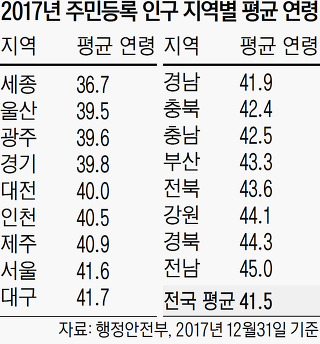

전남과 경북이 평균연령이 매우 높은 편입니다.
전남의 경우는 확진자 수가 적어서 일단 제외하고 경북의 경우를 생각해보겠습니다.
상대적으로 평균 연령이 높은 것이 사망률이 높은 것과 관련이 있는지 생각해볼 필요가 있을 것 같습니다.

In [306]:
# 지역별 코로나 환자 추이
provinces = timeProvince['province'].unique()
isolated = pd.DataFrame(table['confirmed'] - table['deceased'] - table['released'])

fig = make_subplots(rows=6, cols=3, horizontal_spacing=0.03,
                    vertical_spacing= 0.05,
                   subplot_titles=([f'<b>{prov}</b>' for prov in provinces]))

for i, province in enumerate(provinces):
    row, col, legend = i//3 + 1, i%3 + 1, False
    if i == len(provinces)-1 :
        legend = True
    fig.add_trace(go.Scatter(x=table.index, y=table['confirmed'][province],
                     mode='lines', name="Confirmed", 
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[3]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=table['deceased'][province],
                     mode='lines', name="Deceased", 
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[2]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=table['released'][province],
                     mode='lines', name="Released",
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[9]), showlegend=legend), row=row, col=col)
    fig.add_trace(go.Scatter(x=table.index, y=isolated[province],
                     mode='lines', name="Isolated",
                     marker=dict(color = DEFAULT_PLOTLY_COLORS[1]), showlegend=legend), row=row, col=col)

fig.update_layout(title='<b>지역별 환자 추이</b>',
                  height = 2000, font = layout_setting['font'],
                  legend=dict(x=0.7, y=0.05, traceorder="normal",
                             font=dict(family="sans-serif", size=18)))
for i in fig['layout']['annotations']:
    i['font'] = dict(size=20)
    
fig.show()

# PatientInfo 

- 아직 미작업: 연령층/성별/거주지에 따른 확진일(confirm date)과 격리해제 일(released date)/사망일 까지의 소요 기간.  But! 사망한 사람의 데이터 60개뿐(데이터 수 너무 적음)
- 

In [34]:
p_info=pd.read_csv('PatientInfo.csv')

In [35]:
p_info

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,7000000008,9457.0,female,NaN,10s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,25.0,NaN,2020-03-27,NaN,NaN,isolated
3249,7000000009,9651.0,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,14.0,NaN,2020-03-29,NaN,NaN,isolated
3250,7000000010,NaN,female,NaN,20s,Korea,Jeju-do,Jeju-do,NaN,overseas inflow,NaN,NaN,18.0,NaN,2020-04-03,NaN,NaN,isolated
3251,7000000011,NaN,male,NaN,30s,Korea,Jeju-do,Jeju-do,NaN,contact with patient,NaN,7.000000e+09,NaN,NaN,2020-04-03,NaN,NaN,isolated


In [36]:
#일단, 결측치들 너무 많음. 결측치가 없는 컬럼을 기준으로 분석할 예정(state, confirmed_date, province)
p_info.isnull().sum()

patient_id               0
global_num            1171
sex                     53
birth_year             420
age                     61
country                111
province                 0
city                    76
disease               3235
infection_case         812
infection_order       3222
infected_by           2490
contact_number        2656
symptom_onset_date    2791
confirmed_date           0
released_date         2116
deceased_date         3193
state                    0
dtype: int64

## 1. State(격리, 격리해제, 사망자)에 따른 EDA 

In [37]:
p_info['state'].value_counts() #격리, 격리해제, 사망자에 따른 분석 (감염 케이스, 확진 날짜, 성별, 나이, 거주지(위도,경도), 질병여부등에 나눠 시각화,)

isolated    1747
released    1439
deceased      67
Name: state, dtype: int64

In [38]:
isolate_pct = 100 * p_info.query('state == "isolated"').shape[0] / p_info.shape[0]
release_pct = 100 * p_info.query('state == "released"').shape[0] / p_info.shape[0]
decease_pct = 100 * p_info.query('state == "deceased"').shape[0] / p_info.shape[0]

print('전체 환자 중 "격리" 환자는', round(isolate_pct,2),'% 입니다')
print('전체 환자 중 "격리 해제" 환자는', round(release_pct,2),'% 입니다')
print('전체 환자 중 "사망" 환자는', round(decease_pct,2),'% 입니다')

전체 환자 중 "격리" 환자는 53.7 % 입니다
전체 환자 중 "격리 해제" 환자는 44.24 % 입니다
전체 환자 중 "사망" 환자는 2.06 % 입니다


In [39]:
def pie_chart(data, col, title = ''):
    cnt_df = data[col].value_counts().reset_index()
    fig = px.pie(cnt_df, 
                 values = col, 
                 names = 'index', 
                 title = title, 
                 template = 'seaborn',
                 color_discrete_sequence=px.colors.sequential.Reds_r)
    fig.update_traces(rotation=90, pull=0.05, textinfo="value+percent+label")
    fig.show()

In [40]:
pie_chart(p_info, 'state', title = 'Isolated / Released / Deceased') #격리해제 환자수가 많이 급증했음을 볼수 있다. 

### 1-1) 연령층에 따른 state

In [41]:
state_age=p_info.groupby('state')['age'].value_counts()
state_age

state     age 
deceased  80s      21
          70s      18
          60s      11
          50s       7
          90s       7
          40s       2
          30s       1
isolated  20s     375
          50s     302
          60s     235
          40s     218
          30s     217
          70s     121
          80s      99
          10s      71
          90s      27
          0s       24
          100s      1
released  20s     404
          50s     273
          40s     225
          30s     200
          60s     144
          10s      65
          70s      56
          80s      34
          0s       23
          90s      11
Name: age, dtype: int64

In [42]:
stage_age=pd.DataFrame(state_age)

In [43]:
#연령대 컬럼명 변경
stage_age.rename(index={'0s':'0대','10s':'10대','20s':'20대','30s':'30대','40s':'40대','50s':'50대','60s':'60대','70s':'70대','80s':'80대','90s':'90대','100s':'100대'},inplace=True)

In [44]:
stage_age

age
state    age      
deceased 80대    21
         70대    18
         60대    11
         50대     7
         90대     7
         40대     2
         30대     1
isolated 20대   375
         50대   302
         60대   235
         40대   218
         30대   217
         70대   121
         80대    99
         10대    71
         90대    27
         0대     24
         100대    1
released 20대   404
         50대   273
         40대   225
         30대   200
         60대   144
         10대    65
         70대    56
         80대    34
         0대     23
         90대    11

In [45]:
stage_age=stage_age.T
stage_age=stage_age.drop(('isolated','100대'), axis=1, inplace=False) #격리된 연령층 100살대 1개 제외

In [46]:
stage_age=stage_age.T

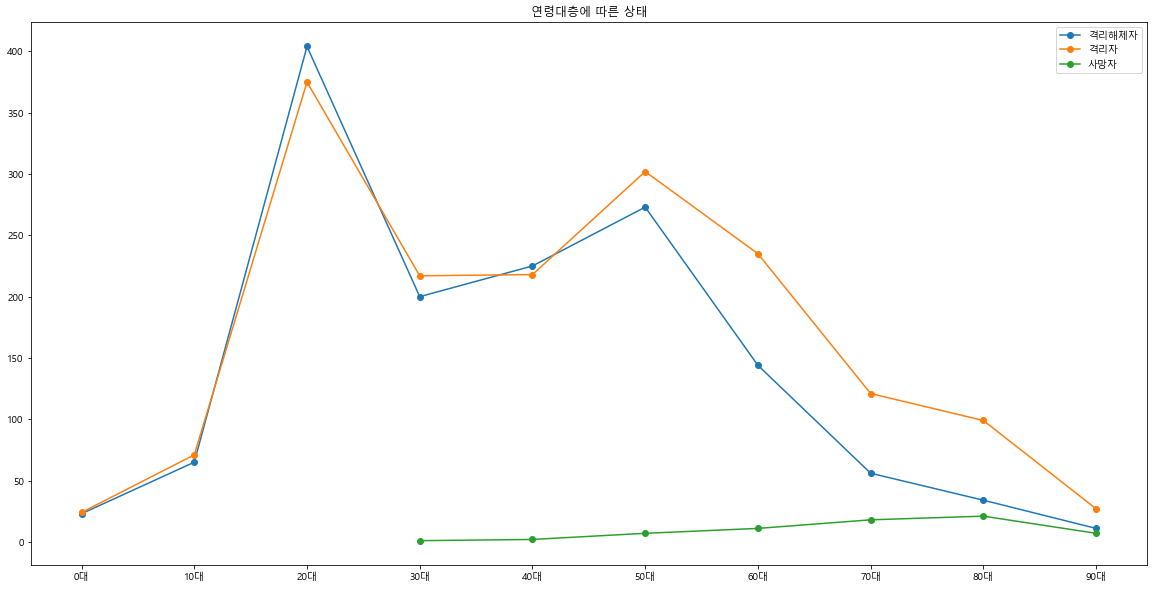

In [47]:
plt.figure(figsize=(20,10))
plt.plot(stage_age.loc['released',:].sort_index(), label='격리해제자', marker='o')
plt.plot(stage_age.loc['isolated',:].sort_index(), label='격리자', marker='o')
plt.plot(stage_age.loc['deceased',:].sort_index(), label='사망자', marker='o')
plt.title("연령대층에 따른 상태")
plt.legend()

#### 연령층별로 알아본 격리/ 격리해제/ 사망 상태

- 가장 많이 격리된 연령층도 20대 , 가장 많이 격리해제가 된 연령층도 20대
-  사망 연령층은 30대부터 시작, 80대가 가장 많음 

### 1-2) 성별에 따른 state

In [48]:
state_sex=pd.DataFrame(p_info.groupby('state')['sex'].value_counts())

In [49]:
state_sex

sex
state    sex        
deceased male     44
         female   23
isolated female  952
         male    743
released female  823
         male    615

In [50]:
state_sex.columns=['count']
state_sex=state_sex.reset_index()

In [51]:
fig=px.bar(state_sex, x='state', y='count', color='sex',title='state별 남/여 비율')
fig.show()

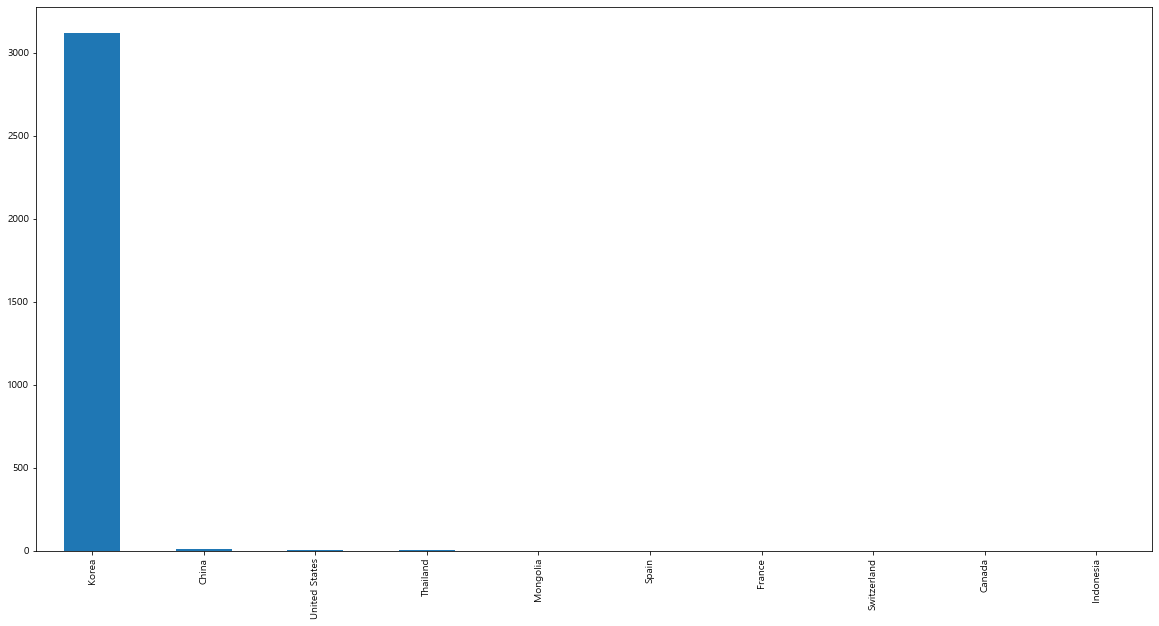

In [52]:
p_info['country'].value_counts().plot.bar(figsize=(20,10)) #환자: 거의 한국인

In [53]:
province_df=pd.DataFrame(p_info['province'].value_counts())

In [54]:
province_df=province_df.reset_index()

In [55]:
fig=px.pie(province_df, values='province', names='index', title='지역별 환자 수 및 비율(%)', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [56]:
city_state=pd.DataFrame(p_info.groupby(['province','city'])['state'].value_counts())

In [57]:
city_state

state
province city        state          
Busan    Buk-gu      released      3
                     isolated      2
         Busanjin-gu isolated      8
                     released      3
                     deceased      2
...                              ...
Ulsan    Nam-gu      released     12
                     isolated      5
                     deceased      1
         Ulju-gun    isolated      2
                     released      2

[283 rows x 1 columns]

In [58]:
city_state=city_state.unstack()
city_state=city_state.fillna(0)

In [59]:
city_state

state                  
state                deceased isolated released
province city                                  
Busan    Buk-gu           0.0      2.0      3.0
         Busanjin-gu      2.0      8.0      3.0
         Dong-gu          0.0      1.0      0.0
         Dongnae-gu       0.0     11.0     22.0
         Gangseo-gu       0.0      0.0      3.0
...                       ...      ...      ...
Ulsan    Buk-gu           0.0      0.0      5.0
         Dong-gu          0.0      0.0      6.0
         Jung-gu          0.0      1.0      8.0
         Nam-gu           1.0      5.0     12.0
         Ulju-gun         0.0      2.0      2.0

[169 rows x 3 columns]

### 1-3) 상태에 따른 지역별 현황

In [60]:
deceased=pd.DataFrame(city_state.loc[:,'state'].loc[:,'deceased']).reset_index()
isolated=pd.DataFrame(city_state.loc[:,'state'].loc[:,'isolated']).reset_index()
released=pd.DataFrame(city_state.loc[:,'state'].loc[:,'released']).reset_index()

#### 지역별 격리해제 환자 수 및 비율 

In [61]:
fig=px.pie(released, values='released', names='province', title='지역별 격리해제 환자 수 및 비율(%)',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#### 지역별 격리 환자 수 및 비율

In [62]:
fig=px.pie(isolated, values='isolated', names='province', title='지역별 격리 환자 수 및 비율(%)',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#### 지역별 사망 환자 수 및 비율

In [63]:
fig=px.pie(deceased, values='deceased', names='province', title='지역별 사망 환자 수 및 비율(%)',color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 1-4) 환자수가 가장 많은 상위 3개 지역 (경상북도, 경기도, 서울시)

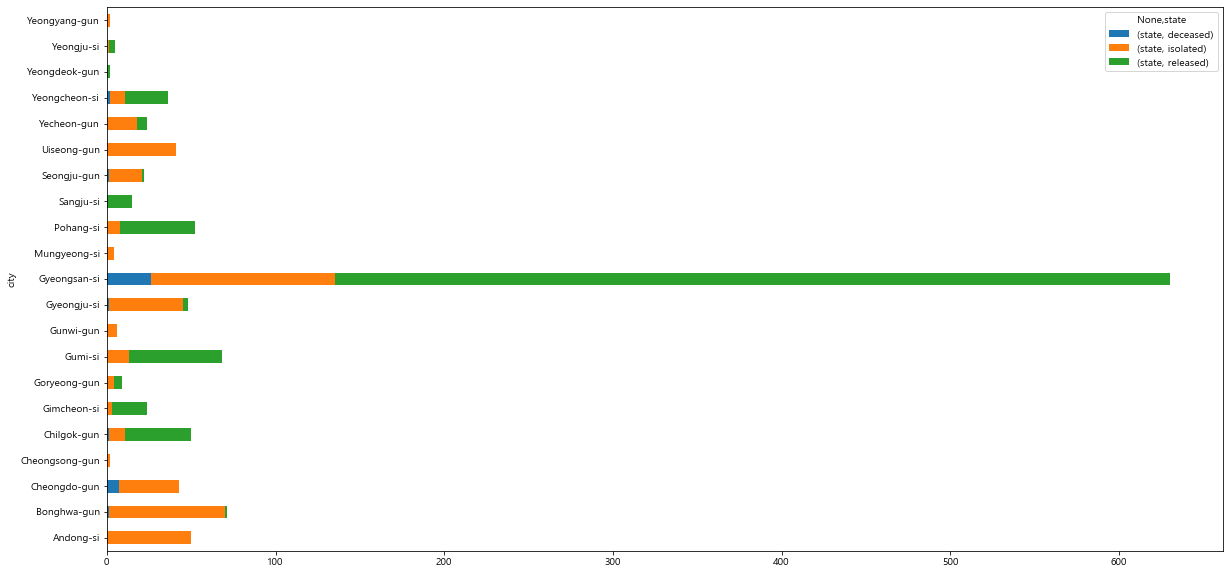

In [64]:
#가장 환자 수가 많았던 경상북도의 city별 state현황 : 경산시가 압도적으로 사망자 수, 격리자 수, 격리해제 수 많음.

city_state.loc['Gyeongsangbuk-do'].plot(kind='barh', figsize=(20,10), stacked=True)

In [65]:
city_state.loc['Gyeongsangbuk-do']

state                  
state          deceased isolated released
city                                     
Andong-si           0.0     50.0      0.0
Bonghwa-gun         1.0     69.0      1.0
Cheongdo-gun        7.0     36.0      0.0
Cheongsong-gun      0.0      2.0      0.0
Chilgok-gun         1.0     10.0     39.0
Gimcheon-si         0.0      3.0     21.0
Goryeong-gun        0.0      4.0      5.0
Gumi-si             0.0     13.0     55.0
Gunwi-gun           0.0      6.0      0.0
Gyeongju-si         1.0     44.0      3.0
Gyeongsan-si       26.0    109.0    495.0
Mungyeong-si        0.0      4.0      0.0
Pohang-si           0.0      8.0     44.0
Sangju-si           0.0      0.0     15.0
Seongju-gun         1.0     20.0      1.0
Uiseong-gun         0.0     41.0      0.0
Yecheon-gun         0.0     18.0      6.0
Yeongcheon-si       2.0      9.0     25.0
Yeongdeok-gun       0.0      0.0      2.0
Yeongju-si          0.0      1.0      4.0
Yeongyang-gun       0.0      2.0      0.0

#### 경상북도 현황
- 경산시(대구시 바로 옆)가 압도적. 격리해제자가 생각보다 495명으로 많다. 
- 신천지 교회가 있는 대구 남구 보다 대구 바로 옆인 경산시에 사망자, 격리자가 훨씬 많음. ?? 대구시에 대한 정보가 부족한듯하다. 대구 외부 데이터 사용해야 할듯하다.

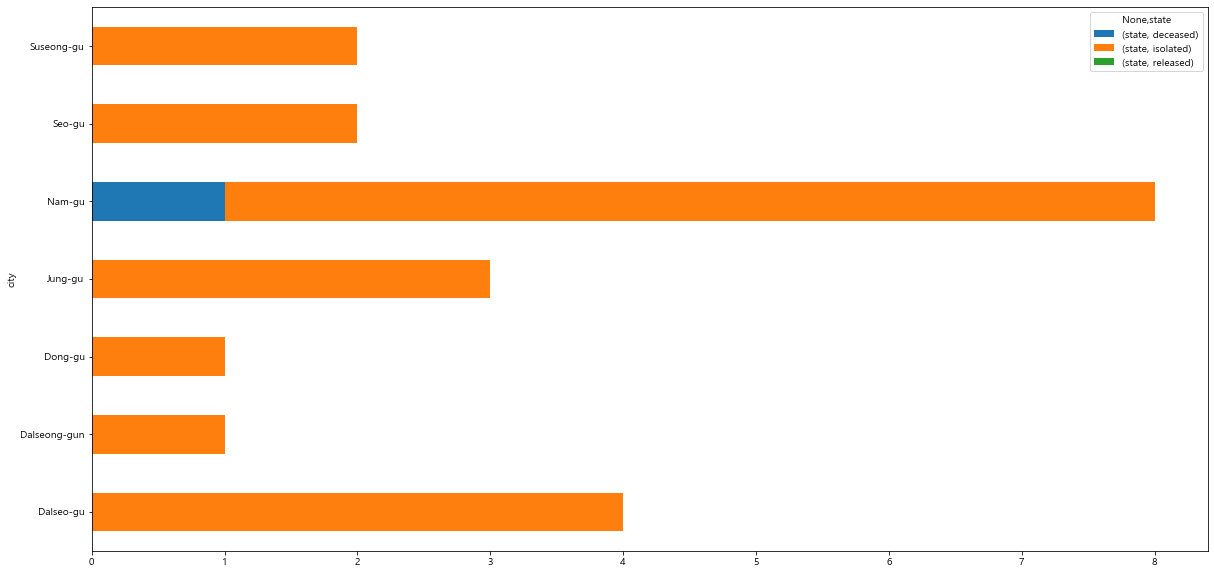

In [66]:
#추가) 대구시 
city_state.loc['Daegu'].plot(kind='barh', figsize=(20,10), stacked=True)

In [67]:
city_state.loc['Daegu']

state                  
state        deceased isolated released
city                                   
Dalseo-gu         0.0      4.0      0.0
Dalseong-gun      0.0      1.0      0.0
Dong-gu           0.0      1.0      0.0
Jung-gu           0.0      3.0      0.0
Nam-gu            1.0      7.0      0.0
Seo-gu            0.0      2.0      0.0
Suseong-gu        0.0      2.0      0.0

#### 대구시
- 신천지 교회 소재지인 대구 남구에 사망자 1명, 격리자 7명 

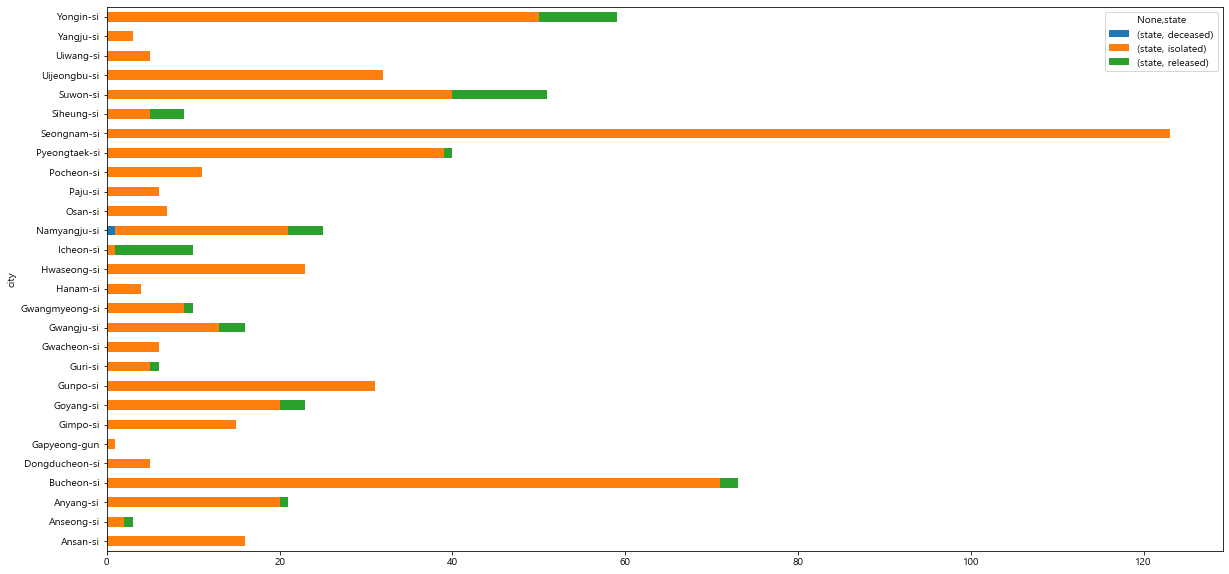

In [68]:
#경기도 city별 state 
city_state.loc['Gyeonggi-do'].plot(kind='barh', figsize=(20,10), stacked=True)

In [69]:
city_state.loc['Gyeonggi-do']

state                  
state          deceased isolated released
city                                     
Ansan-si            0.0     16.0      0.0
Anseong-si          0.0      2.0      1.0
Anyang-si           0.0     20.0      1.0
Bucheon-si          0.0     71.0      2.0
Dongducheon-si      0.0      5.0      0.0
Gapyeong-gun        0.0      1.0      0.0
Gimpo-si            0.0     15.0      0.0
Goyang-si           0.0     20.0      3.0
Gunpo-si            0.0     31.0      0.0
Guri-si             0.0      5.0      1.0
Gwacheon-si         0.0      6.0      0.0
Gwangju-si          0.0     13.0      3.0
Gwangmyeong-si      0.0      9.0      1.0
Hanam-si            0.0      4.0      0.0
Hwaseong-si         0.0     23.0      0.0
Icheon-si           0.0      1.0      9.0
Namyangju-si        1.0     20.0      4.0
Osan-si             0.0      7.0      0.0
Paju-si             0.0      6.0      0.0
Pocheon-si          0.0     11.0      0.0
Pyeongtaek-si       0.0     39.0      1.0
Seongnam-si         0.0    123.0      0.0
Siheung-si          0.0      5.0      4.0
Suwon-si            0.0     40.0     11.0
Uijeongbu-si        0.0     32.0      0.0
Uiwang-si           0.0      5.0      0.0
Yangju-si           0.0      3.0      0.0
Yongin-si           0.0     50.0      9.0

#### 경기도 현황
- 경기도에는 성남시가 압도적으로 격리자 수(123명)가 많다.
- 사망자는 대체적으로 없고 남양주시에서만 1명 있다는 것 확인.
- 격리해제자도 대체적으로 거의 없음을 확인.  

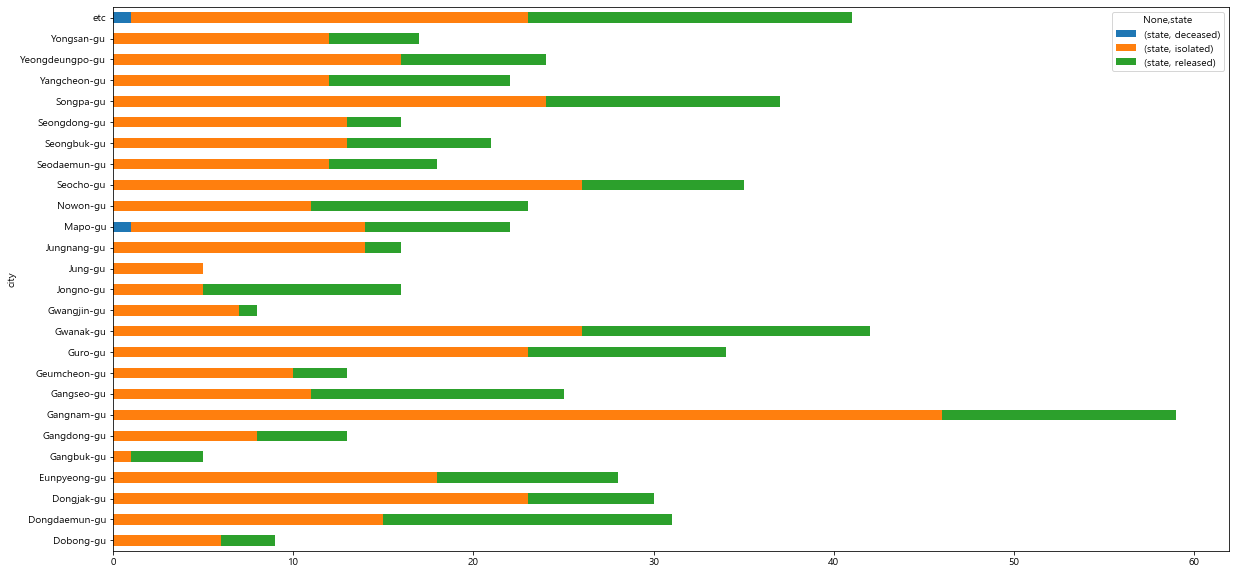

In [70]:
#서울의 city별 state
city_state.loc['Seoul'].plot(kind='barh', figsize=(20,10), stacked=True)

In [71]:
city_state.loc['Seoul']

state                  
state           deceased isolated released
city                                      
Dobong-gu            0.0      6.0      3.0
Dongdaemun-gu        0.0     15.0     16.0
Dongjak-gu           0.0     23.0      7.0
Eunpyeong-gu         0.0     18.0     10.0
Gangbuk-gu           0.0      1.0      4.0
Gangdong-gu          0.0      8.0      5.0
Gangnam-gu           0.0     46.0     13.0
Gangseo-gu           0.0     11.0     14.0
Geumcheon-gu         0.0     10.0      3.0
Guro-gu              0.0     23.0     11.0
Gwanak-gu            0.0     26.0     16.0
Gwangjin-gu          0.0      7.0      1.0
Jongno-gu            0.0      5.0     11.0
Jung-gu              0.0      5.0      0.0
Jungnang-gu          0.0     14.0      2.0
Mapo-gu              1.0     13.0      8.0
Nowon-gu             0.0     11.0     12.0
Seocho-gu            0.0     26.0      9.0
Seodaemun-gu         0.0     12.0      6.0
Seongbuk-gu          0.0     13.0      8.0
Seongdong-gu         0.0     13.0      3.0
Songpa-gu            0.0     24.0     13.0
Yangcheon-gu         0.0     12.0     10.0
Yeongdeungpo-gu      0.0     16.0      8.0
Yongsan-gu           0.0     12.0      5.0
etc                  1.0     22.0     18.0

#### 서울 현황
- 강남구 : 격리자(46명), 격리해제자(13명)
- 관악구 : 격리자(26명) , 격리해제자(16명)
- 서초구 : 격리자(26명), 격리해제자(9명)
- 송파구 : 격리자(24명), 격리해제자(13명)
- 구로구 : 격리자(23명), 격리해제자(11명) + 구로구 콜센터 집단감염과 연관?.
- 동작구 : 격리자(23명), 격리해제자(7명)
- 마포구 : 유일한 사망자: 1명, 격리자(13명), 격리해제자(8명)

### 2) 감염 케이스에 따른 State 

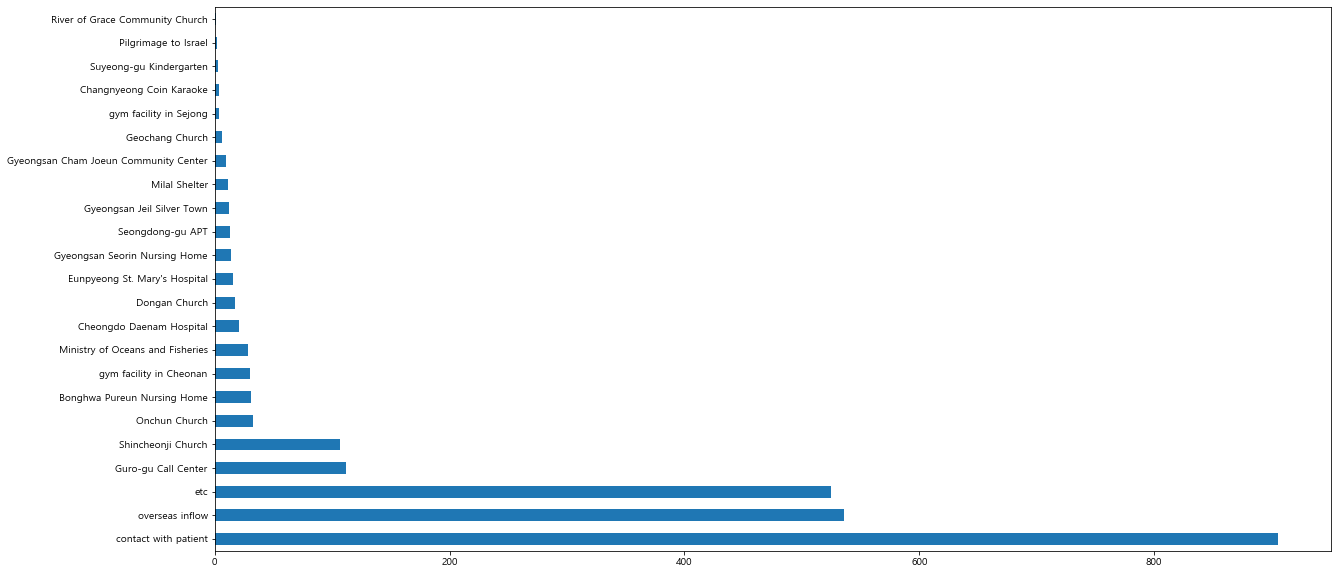

In [72]:
p_info['infection_case'].value_counts().plot.barh(figsize=(20,10))

#환자끼리와의 접촉이 가장 많음

In [73]:
case_state=pd.DataFrame(p_info.groupby('infection_case')['state'].value_counts())

In [74]:
case_state=case_state.unstack(level=0)

In [75]:
case_state

state                           \
infection_case Bonghwa Pureun Nursing Home Changnyeong Coin Karaoke   
state                                                                 
deceased                               1.0                      NaN   
isolated                              30.0                      NaN   
released                               NaN                      4.0   

                                                       \
infection_case Cheongdo Daenam Hospital Dongan Church   
state                                                   
deceased                            7.0           NaN   
isolated                           13.0          11.0   
released                            1.0           6.0   

                                                              \
infection_case Eunpyeong St. Mary's Hospital Geochang Church   
state                                                          
deceased                                 NaN             NaN   
isolated                                 5.0             NaN   
released                                11.0             6.0   

                                                                          \
infection_case Guro-gu Call Center Gyeongsan Cham Joeun Community Center   
state                                                                      
deceased                       1.0                                   NaN   
isolated                      53.0                                   3.0   
released                      58.0                                   7.0   

                                                                         ...  \
infection_case Gyeongsan Jeil Silver Town Gyeongsan Seorin Nursing Home  ...   
state                                                                    ...   
deceased                              1.0                           NaN  ...   
isolated                              2.0                           9.0  ...   
released                              9.0                           5.0  ...   

                                                                     \
infection_case Pilgrimage to Israel River of Grace Community Church   
state                                                                 
deceased                        NaN                             NaN   
isolated                        NaN                             NaN   
released                        2.0                             1.0   

                                                                            \
infection_case Seongdong-gu APT Shincheonji Church Suyeong-gu Kindergarten   
state                                                                        
deceased                    NaN                2.0                     NaN   
isolated                    2.0               36.0                     NaN   
released                   11.0               69.0                     3.0   

                                                                    \
infection_case contact with patient    etc gym facility in Cheonan   
state                                                                
deceased                        3.0   13.0                     NaN   
isolated                      582.0  262.0                     5.0   
released                      320.0  250.0                    25.0   

                                                       
infection_case gym facility in Sejong overseas inflow  
state                                                  
deceased                          NaN             NaN  
isolated                          1.0           469.0  
released                          3.0            67.0  

[3 rows x 23 columns]

In [76]:
case_state.iplot(kind='barh', barmode="stack",title='state별 감염 케이스')

In [77]:
#격리해제자 수/격리자 수/사망자 수 가장 많은 감염 경우 부터
p_info.groupby('infection_case')['state'].value_counts().sort_values(ascending=False)

infection_case                         state   
contact with patient                   isolated    582
overseas inflow                        isolated    469
contact with patient                   released    320
etc                                    isolated    262
                                       released    250
Shincheonji Church                     released     69
overseas inflow                        released     67
Guro-gu Call Center                    released     58
                                       isolated     53
Shincheonji Church                     isolated     36
Bonghwa Pureun Nursing Home            isolated     30
Onchun Church                          released     28
gym facility in Cheonan                released     25
Ministry of Oceans and Fisheries       isolated     16
Cheongdo Daenam Hospital               isolated     13
etc                                    deceased     13
Ministry of Oceans and Fisheries       released     12
Seongdong-gu APT 

#### 감염 케이스

- 격리해제자 : 다른환자와의 접촉(320명) > 기타(250명) > 신천지교회(69명) > 구로콜센터(58명) > 온천교회(28명) > 천안 체육관(25명) > ...

- 격리자 : 다른환자와의 접촉(582명) >  해외(469명) > 기타(262명) > 구로콜센터(53명) > 신천지교회(36명) > 봉화푸른요양원(30명) > ..

- 사망자 : 기타(13명) > 청도대남병원(7명) > 다른 환자와의 접촉(3명) > 신천지교회(2명) > 구로콜센터(1명) ..


- 결론: 다른환자와의 접촉 사례가 가장 큼, 최근 해외에서 온 격리자 수가 많아졌음을 알 수 있다.

# Route data 설계

- 위도/ 경도가 있고 환자번호(patient_id)가 있음으로 patientinfo data와 merge시켜서 활용 가능. ex) 상태에 따른 환자 감염 위치 표시 가능



In [78]:
route=pd.read_csv('PatientRoute.csv')

In [79]:
route

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534
...,...,...,...,...,...,...,...,...
5316,6100000090,NaN,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474
5317,6100000090,NaN,2020-03-24,Busan,Gangseo-gu,airport,35.173220,128.946459
5318,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389
5319,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,hospital,35.335757,129.025003


In [80]:
route.shape

(5321, 8)

In [81]:
route['patient_id'].value_counts() #총 939명의 환자의 동선

3009000014    42
1400000021    38
3009000013    37
1100000069    35
3009000003    33
              ..
6100000082     1
6020100107     1
1100000062     1
1400000012     1
6023000044     1
Name: patient_id, Length: 939, dtype: int64

### 1) 환자 이동 장소 유형 

In [82]:
type_infection=pd.DataFrame(route['type'].value_counts())
type_infection=type_infection.reset_index()

In [83]:
fig=px.pie(type_infection, values='type', names='index', title='[환자 이동 장소 유형 수 및 비율(%)]')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#### 감염자가 이동한 장소 

- 기타가 제일 높은 비율 차지. 기타가 뭘지일지는 추후 찾아볼 예정.
- 기타와 병원이 60%로 비율 차지.

### 2) 확진자별 이동경로 

In [307]:
#Patients가 939명 이다 보니 많아서 이동경로가 너무 지저분함 => 깔끔하게 특정 patients만 나타내는 방법도 괜찮을듯..
fig = px.line_mapbox(route, lat = 'latitude', lon = 'longitude', color = 'patient_id', zoom=7)
fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [85]:
fig_map = px.scatter_mapbox(route, lat="latitude", lon="longitude",
                color_continuous_scale="Rainbow", size_max=50)
fig_map.update_layout(mapbox_style="carto-positron",width=900, height=700)
fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_map.show()

In [86]:
route_by_pinfo=pd.merge(route, p_info, how="left")

In [87]:
route_by_pinfo

,patient_id,global_num,date,province,city,type,latitude,longitude,sex,birth_year,...,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.615246,126.715632,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000000001,2.0,2020-01-24,Seoul,Jung-gu,hospital,37.567241,127.005659,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000000002,5.0,2020-01-25,Seoul,Seongbuk-gu,etc,37.592560,127.017048,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000000002,5.0,2020-01-26,Seoul,Seongbuk-gu,store,37.591810,127.016822,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000000002,5.0,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.563992,127.029534,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5316,6100000090,NaN,2020-03-24,Seoul,Gangseo-gu,airport,37.558654,126.794474,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5317,6100000090,NaN,2020-03-24,Busan,Gangseo-gu,airport,35.173220,128.946459,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5318,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,store,35.336944,129.026389,male,1980.0,...,NaN,overseas inflow,NaN,NaN,NaN,2020-03-25,2020-03-26,NaN,NaN,isolated
5319,6100000090,NaN,2020-03-25,Gyeongsangnam-do,Yangsan-si,hospital,35.335757,129.025003,male,1980.0,...,NaN,overseas inflow,NaN,NaN,NaN,2020-03-25,2020-03-26,NaN,NaN,isolated


# Case data 설계 

### 1) 감염 경우(위치)별 확진자 수  

In [88]:
case=pd.read_csv('Case.csv')

In [89]:
case.info() #latitude, longitude 자료형 object?? float형으로 변환

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 8 columns):
case_id           111 non-null int64
province          111 non-null object
city              111 non-null object
group             111 non-null bool
infection_case    111 non-null object
confirmed         111 non-null int64
latitude          111 non-null object
longitude         111 non-null object
dtypes: bool(1), int64(2), object(5)
memory usage: 6.3+ KB


In [90]:
case[['latitude','longitude']]=np.where(case[['latitude','longitude']]=='-',None,case[['latitude','longitude']])

In [91]:
case[['latitude','longitude']]=case[['latitude','longitude']].astype(float)

In [92]:
fig_map = px.scatter_mapbox(case, lat="latitude", lon="longitude", color='case_id',
                color_continuous_scale="Rainbow", size='confirmed', size_max=50, zoom=7)
fig_map.update_layout(mapbox_style="carto-positron",width=900, height=700)
fig_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0}) #margin(layout 크기) 맞춤
fig_map.show()